In [1]:
%matplotlib notebook

colors = np.asarray([
"#8dd3c7",
"#ffffb3",
"#bebada",
"#fb8072",
"#80b1d3",
"#fdb462",
"#b3de69"])

plt.rc('font', family='serif')

In [2]:
from dynetlsm.datasets.samples_generator import network_from_dynamic_latent_space
n_nodes = 100
n_features = 2

rng = np.random.RandomState(42)

mus  = np.array([[5,  0],
                 [-5, 0],
                 [0, 0]])
sigma = [1.0, 1.0, 1.0]
lmbda = 0.2

X, z = [], []
z0 = rng.choice([0, 1], p=[0.5, 0.5], size=n_nodes)
X0 = sigma[1] * rng.randn(n_nodes, n_features) + mus[z0]
X.append(X0)
z.append(z0)

for t in range(1, 5):
    Xt = (1 - lmbda) * X[t-1] + sigma[-1] * rng.randn(n_nodes, n_features)
    X.append(Xt)
    z.append(2 * np.ones(n_nodes))

X = np.asarray(X)
z = np.asarray(z).astype(int)

Y, probas = network_from_dynamic_latent_space(X)

In [78]:
from dynetlsm.datasets.samples_generator import merging_dynamic_network

Y, X, z, intercept, probas, mus, sigmas = merging_dynamic_network(
    n_nodes=120, lmbda=0.6, n_time_steps=5, random_state=42)




[0.75 0.   0.25]
[0.5 0.  0.5]


<IPython.core.display.Javascript object>


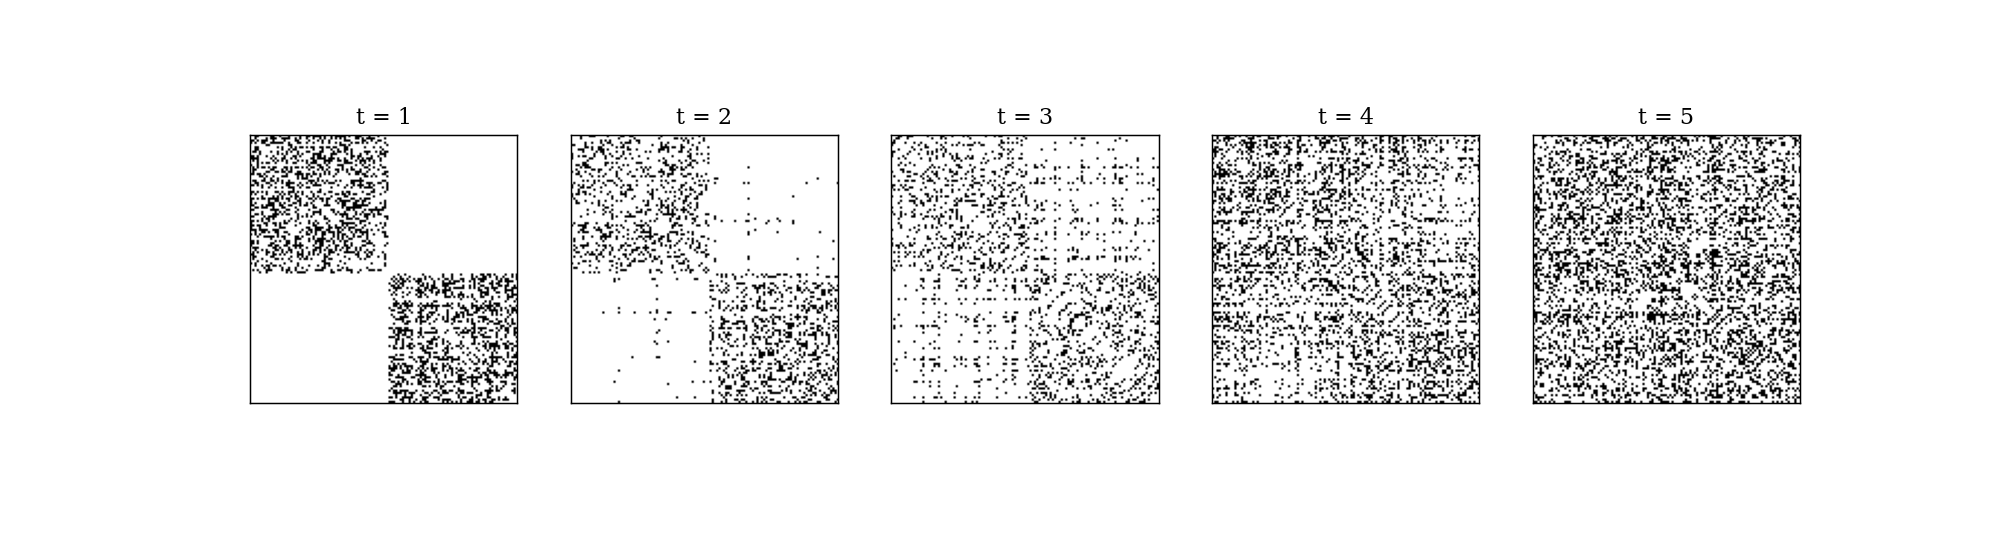

In [28]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=Y.shape[0], 
                       nrows=1, sharex=True, sharey=True)
ax = ax.flat
order = np.argsort(z[0])
for t in range(Y.shape[0]):
    ax[t].imshow(Y[t][order, :][:, order], cmap='gray_r')
    ax[t].xaxis.set_visible(False)
    ax[t].yaxis.set_visible(False)
    ax[t].set_title('t = {}'.format(t+1))

    
#fig.savefig('/Users/joshua/Documents/StatisticsUIUC/JournalClub/visiting-day-2021/'
#            'images/abrupt.pdf', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


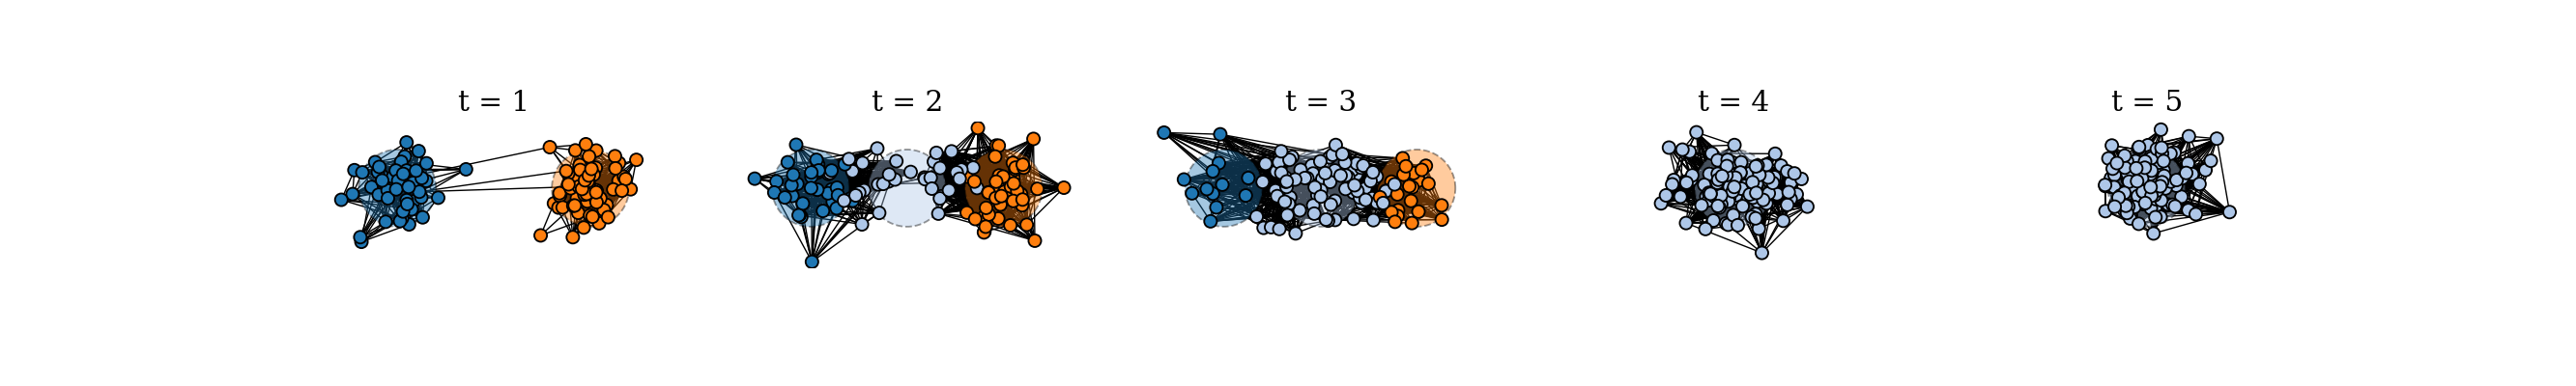

In [26]:
import networkx as nx

from dynetlsm.plots import get_colors, normal_contour

#colors = get_colors(z[0])


t = 0


G = nx.from_numpy_array(Y[t])

fig, ax = plt.subplots(figsize=(20, 3), #ncols=Y.shape[0], 
                       ncols=5, nrows=1, sharex=True, sharey=True, 
                       subplot_kw=dict(aspect=1))
ax = ax.flat

for t in range(Y.shape[0]):
    pos = dict()
    for i in range(Y.shape[1]):
        pos[i] = X[t, i]
    
    nx.draw(G, pos=pos, 
        node_color=colors[z[t]], 
        edge_color='k', edgecolors='k',
        node_size=50,
        width=0.75, ax=ax[t])

    for k in np.unique(z[t]):
        normal_contour(mus[k], sigmas[k] * np.eye(2), ax=ax[t], n_std=[2],
                   zorder=1, alpha=0.4, facecolor=colors[k], linestyle='--',
                   linewidth=1, edgecolor='k')

    #ax.set_aspect('equal', 'box')
    ax[t].set_title('t = {}'.format(t + 1), fontsize=16)



In [79]:
from dynetlsm import DynamicNetworkHDPLPCM

model = DynamicNetworkHDPLPCM(
    n_components=10, n_iter=20000, burn=10000, tune=5000, tune_interval=1000,
    lambda_variance_prior=1).fit(Y)

100%|██████████| 34999/34999 [1:16:06<00:00,  7.66it/s]


<IPython.core.display.Javascript object>


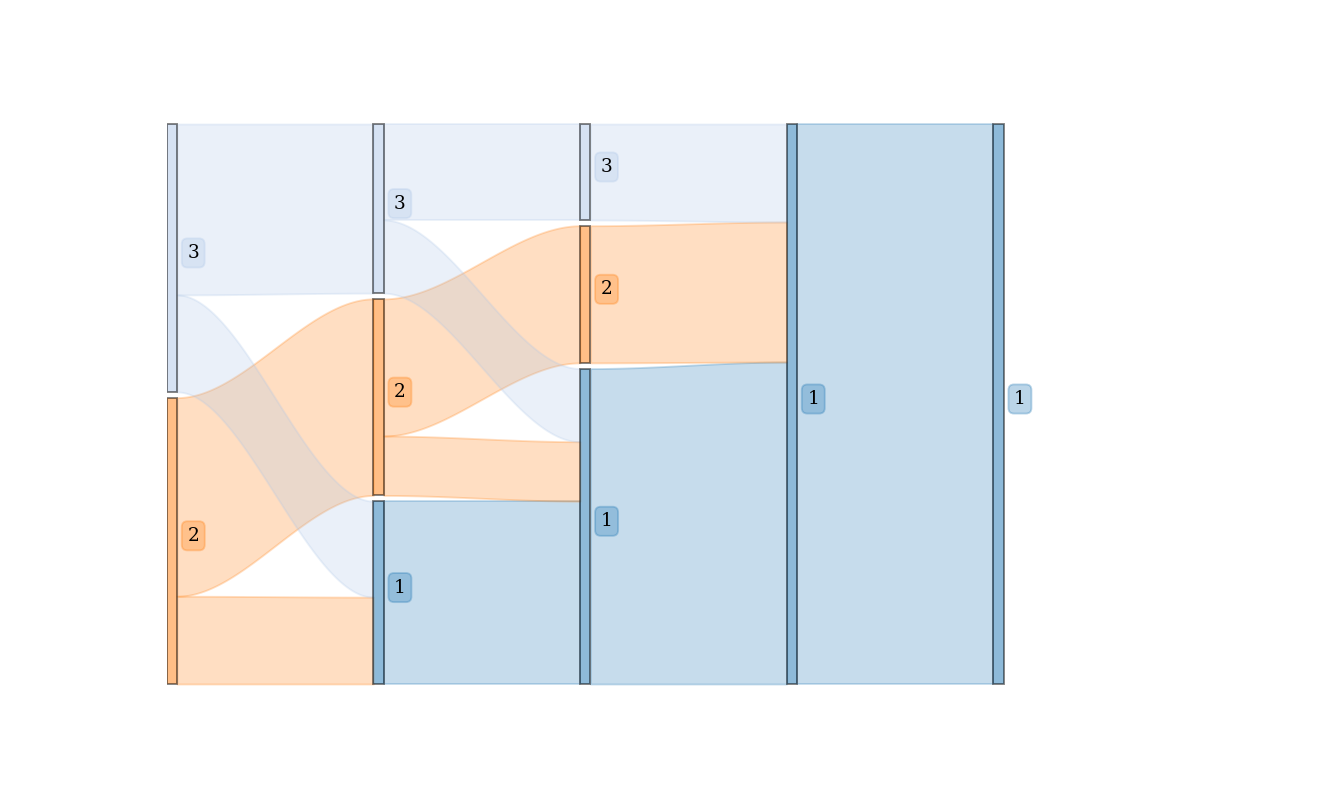

(<Figure size 1000x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1347f4670>)

In [84]:
from dynetlsm.plots import alluvial_plot

alluvial_plot(model.z_)

<IPython.core.display.Javascript object>


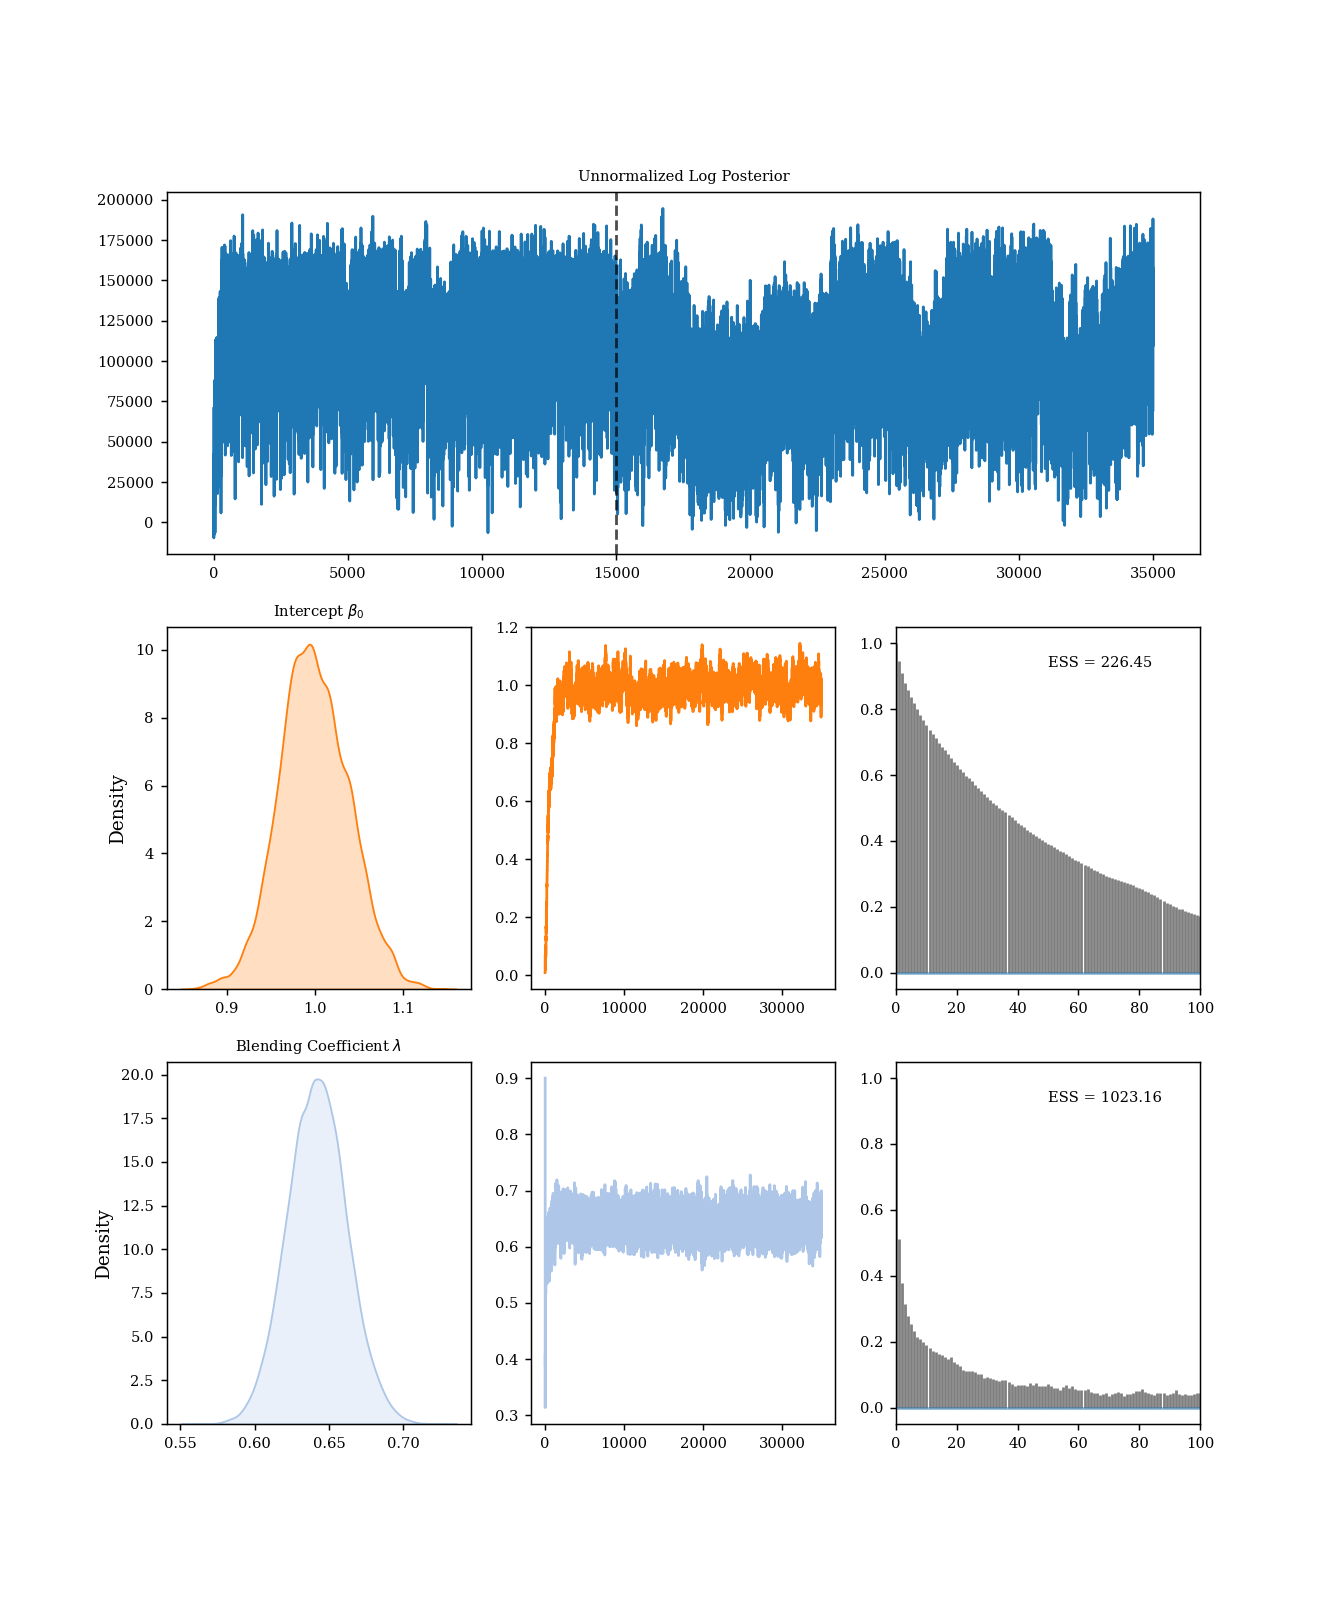

(<Figure size 1000x1200 with 7 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e1f9040>,
         None, None],
       dtype=object))

In [75]:
from dynetlsm.plots import plot_traces

plot_traces(model)

<IPython.core.display.Javascript object>


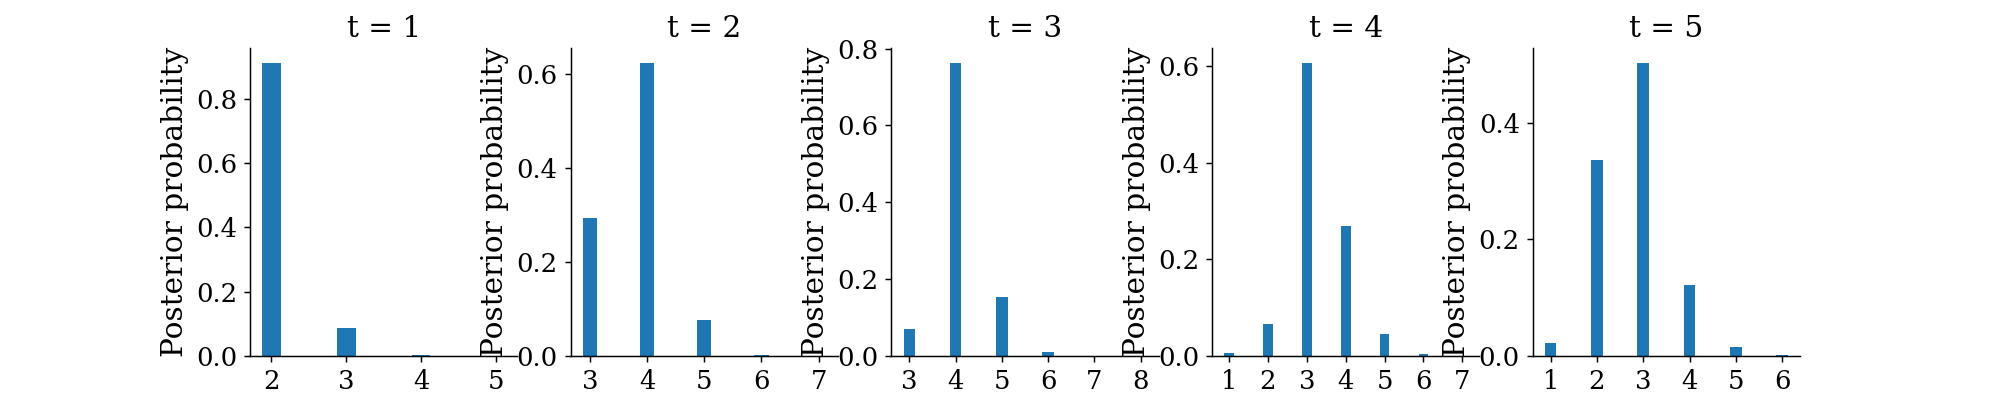

In [83]:
from dynetlsm.plots import plot_posterior_counts

fig, ax = plt.subplots(figsize=(15, 3), ncols=5)

for t in range(Y.shape[0]):
    plot_posterior_counts(model, t=t, ax=ax[t])

In [65]:
model.trans_weights_[-1]

array([[2.69182721e-001, 7.30817279e-001, 1.80340345e-259],
       [2.61836228e-047, 1.00000000e+000, 2.00556262e-245],
       [1.06695089e-005, 2.01619539e-001, 7.98369792e-001]])

In [62]:
model.lambda_mean_

array([0.64208029])

<IPython.core.display.Javascript object>


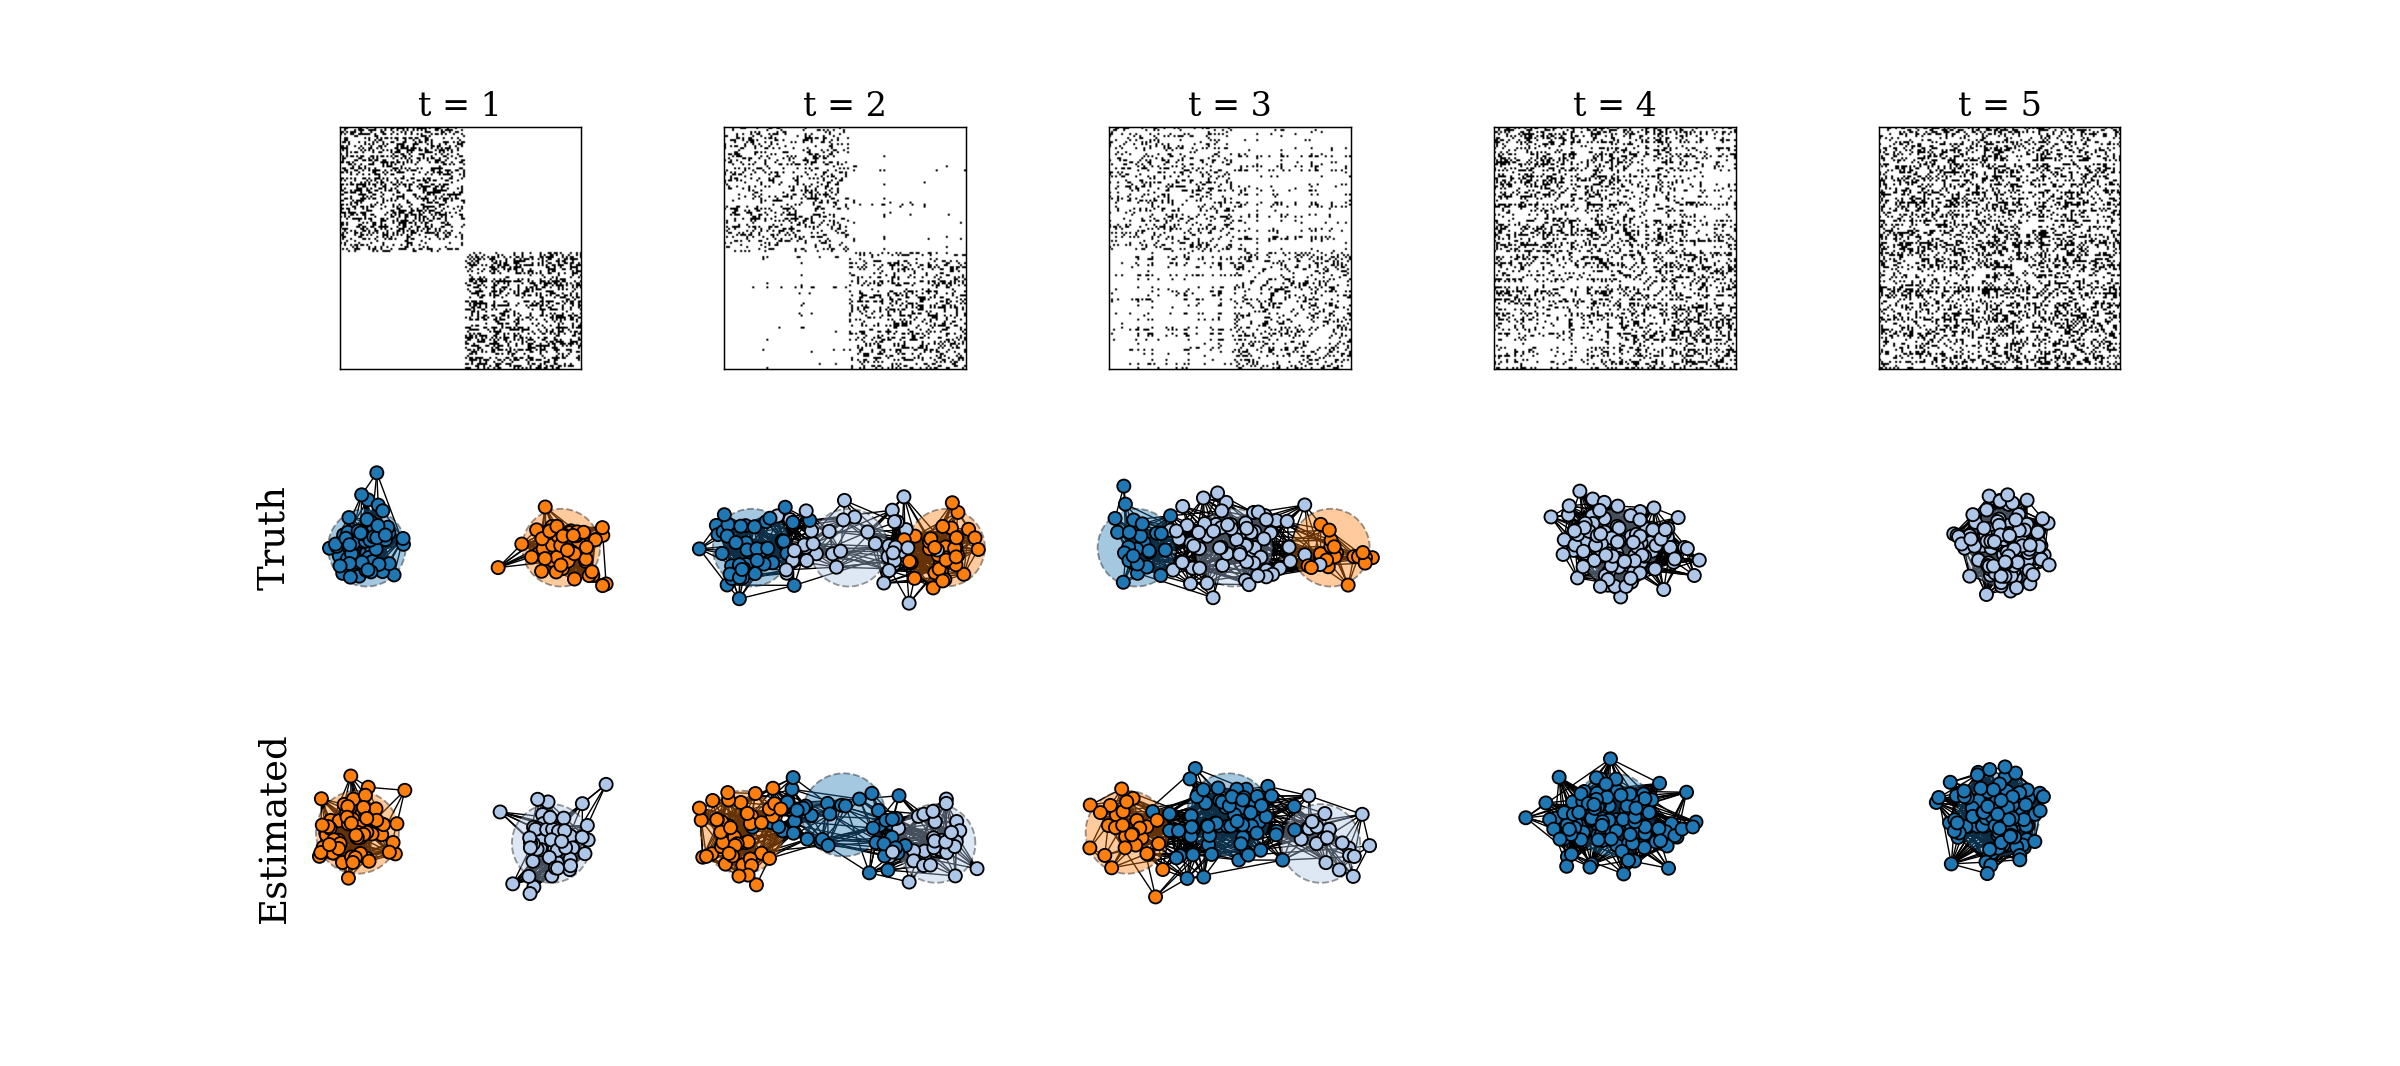

In [82]:
import networkx as nx

from dynetlsm.plots import get_colors, normal_contour
from dynetlsm.procrustes import longitudinal_procrustes_rotation

colors = get_colors(z[0])


t = 0




fig, ax = plt.subplots(figsize=(18, 8), ncols=5, nrows=3,
                       sharey='row', sharex='row', subplot_kw=dict(aspect=1))

X_rot, R = longitudinal_procrustes_rotation(X, model.X_)
mu_rot = np.dot(model.mu_, R)


order = np.argsort(z[0])
for t in range(Y.shape[0]):
    ax[0, t].imshow(Y[t][order, :][:, order], cmap='gray_r')
    ax[0, t].xaxis.set_visible(False)
    ax[0, t].yaxis.set_visible(False)
    ax[0, t].set_title('t = {}'.format(t+1), fontsize=18)

    
for t in range(Y.shape[0]):
    pos = dict()
    for i in range(Y.shape[1]):
        pos[i] = X[t, i]
    
    G = nx.from_numpy_array(Y[t])
    
    nx.draw(G, pos=pos, 
        node_color=colors[z[t]], 
        edge_color='k', edgecolors='k',
        node_size=50,
        width=0.75, ax=ax[1, t])

    for k in np.unique(z[t]):
        normal_contour(mus[k], sigmas[k] * np.eye(2), ax=ax[1, t], n_std=[2],
                   zorder=1, alpha=0.4, facecolor=colors[k], linestyle='--',
                   linewidth=1, edgecolor='k')

    #ax.set_aspect('equal', 'box')
    #ax[0, t].set_title('t = {}'.format(t + 1), fontsize=16)
    
    if t == 0:
        ax[1, t].axis('on')
        ax[1, t].spines['top'].set_visible(False)
        ax[1, t].spines['right'].set_visible(False)
        ax[1, t].spines['bottom'].set_visible(False)
        ax[1, t].spines['left'].set_visible(False)
        ax[1, t].set_ylabel('Truth', fontsize=20)
    
    ax[1, t].margins(y=0.1)

for t in range(Y.shape[0]):
    pos = dict()
    for i in range(Y.shape[1]):
        pos[i] = X_rot[t, i]
    
    G = nx.from_numpy_array(Y[t])
    
    nx.draw(G, pos=pos, 
        node_color=colors[model.z_[t]], 
        #node_color=colors[z[t]],
        edge_color='k', edgecolors='k',
        node_size=50,
        width=0.75, ax=ax[2, t])

    for k in np.unique(model.z_[t]):
        normal_contour(mu_rot[k], model.sigma_[k] * np.eye(2), ax=ax[2, t], n_std=[2],
                   zorder=1, alpha=0.4, facecolor=colors[k], linestyle='--',
                   linewidth=1, edgecolor='k')

    #ax.set_aspect('equal', 'box')
    #ax[t].set_title('t = {}'.format(t + 1), fontsize=16)
    if t == 0:
        ax[2, t].axis('on')
        ax[2, t].spines['top'].set_visible(False)
        ax[2, t].spines['right'].set_visible(False)
        ax[2, t].spines['bottom'].set_visible(False)
        ax[2, t].spines['left'].set_visible(False)
        ax[2, t].set_ylabel('Estimated', fontsize=20)
    
    ax[2, t].margins(y=0.1)

#fig.savefig('/Users/joshua/myworkspace/hdp-lpcm-ba/images/merging_communities2.pdf', dpi=300, bbox_inches='tight')

In [81]:
np.quantile(model.lambdas_[model.n_burn_:], q=[0.025, 0.975])

array([0.59416624, 0.67348207])

In [85]:
model.lambda_mean_

array([0.63232399])

In [42]:
import joblib

joblib.dump(model, open('merging.pkl', 'wb'))

In [44]:
zero_mask = model.z_ == 0
one_mask = model.z_ == 1
two_mask = model.z_ == 2
model.z_[zero_mask] = 1
model.z_[one_mask] = 2
model.z_[two_mask] = 0

In [53]:
#mu = model.mu_.copy()
model.mu_ = model.mu_[[2, 0, 1], :]
model.sigma_ = model.sigma_[[2, 0, 1]]

In [52]:
model.mu_

array([[ 3.54896028, -3.48053013],
       [ 0.19579239, -0.40537875],
       [-3.56742301,  3.55017139]])

In [130]:
mus *= -1

In [122]:
mu_rot

array([[ 5.33207039, -0.34289168],
       [-4.87903521,  0.06665405],
       [ 0.31864217,  0.17368702]])

In [38]:
model.lambda_

array([0.63488])

In [86]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(z.ravel(), model.z_.ravel())

0.9310155991661274

<IPython.core.display.Javascript object>


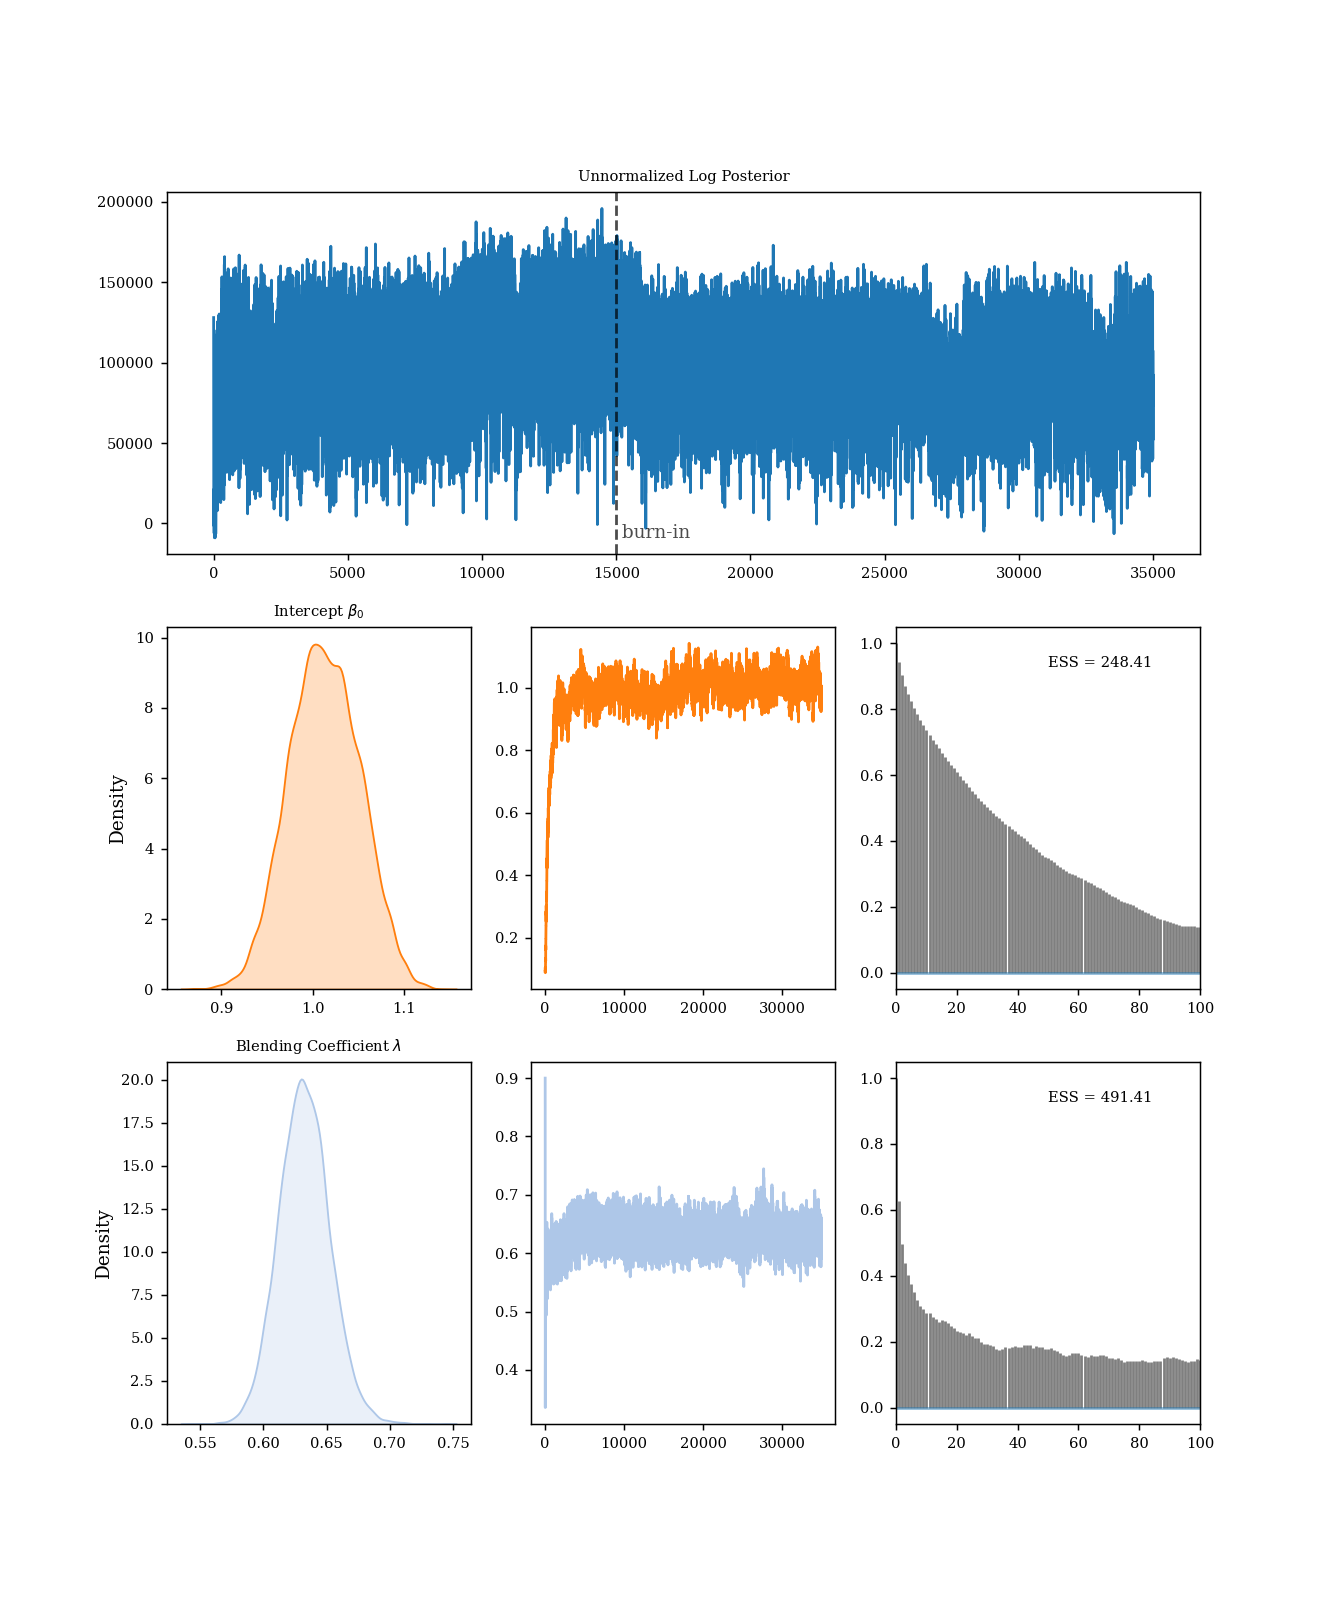

(<Figure size 1000x1200 with 7 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14a0c3910>,
         None, None],
       dtype=object))

In [87]:
from dynetlsm.plots import plot_traces

plot_traces(model)